# Validate network propagation simulation using Autism genes

------

Brin Rosenthal (sbrosenthal@ucsd.edu)


--------

In [1]:
# import standard scientific computing tools
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import networkx as nx 

# use mygene.info to translate between entrez and gene symbol
import mygene 
mg = mygene.MyGeneInfo()


# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

# allow for in-cell plotting
% matplotlib inline

# import the visJS2jupyter tool
import visJS2jupyter.visJS_module 
import visJS2jupyter.visualizations


# Load STRING interactome

- Download and unzip the human STRING interactome from this link https://string-db.org/download/protein.links.v10.5/9606.protein.links.v10.5.txt.gz

- Then load the interactome into a networkX object using the load_STRING function

- **Note**: make sure to set the path to the correct download location!

In [2]:
def load_STRING(datafile = '../interactomes/string_human/9606.protein.links.v10.txt',conf_thresh=700,species='human'):
    '''
    Helper function to parse and load STRING network
    
    '''
    
    string_df = pd.read_csv(datafile,sep=' ')
    string_df = string_df.loc[string_df['combined_score']>conf_thresh]
                              
    # create the network
    G_str = nx.Graph()
    G_str.add_weighted_edges_from(zip(string_df['protein1'],string_df['protein2'],string_df['combined_score']))
    
    # convert from ensembleID to gene symbol
    string_genes_temp = [n[n.find('.')+1:] for n in G_str.nodes()]

    mg_temp = mg.querymany(string_genes_temp,scopes='ensemblprotein',fields='symbol',species=species)
    ensembl_list = [x['query'] for x in mg_temp]
    symbol_list = [x['symbol'] if 'symbol' in x.keys() else 'None' for x in mg_temp]
    ensembl_to_symbol = dict(zip(ensembl_list,symbol_list))
    ensembl_to_symbol = pd.Series(ensembl_to_symbol)
    
    # relabel nodes with symbols
    G_str = nx.relabel_nodes(G_str,dict(zip(G_str.nodes(),string_genes_temp)))
    G_str = nx.relabel_nodes(G_str,dict(ensembl_to_symbol[ensembl_to_symbol!='None']))  # only keep the proteins that have associated genes
    
    return G_str


In [3]:
# load the string interactome
# NOTE: MAKE SURE TO SET THE PATH TO WHERE YOU DOWNLOADED THE STRING DATABASE
G_str = load_STRING('../../interactomes/string_human/9606.protein.links.v10.txt',
                                     conf_thresh=700,species='human')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-15478...done.
Finished.
2 input query terms found dup hits:
	[(u'ENSP00000435010', 2), (u'ENSP00000419718', 2)]
745 input query terms found no hit:
	[u'ENSP00000265335', u'ENSP00000393912', u'ENSP00000361280', u'ENSP00000362398', u'ENSP00000338190',
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


# Load the autism risk genes

- Autism risk genes obtained from SFARI database (https://gene.sfari.org/)

In [4]:
ASD_df = pd.read_csv('gene-report.csv',)

ASD_genes = ASD_df['Gene Symbol'].unique().tolist()

print(len(ASD_genes)) # how many unique ASD genes are in the table?
ASD_genes = list(np.intersect1d(ASD_genes,G_str.nodes())) # only keep genes in STRING

len(ASD_genes) # how many genes ASD risk genes are found in the STRING high confidence interactome?

859


751

# Pre-calculate the normalized adjacency matrix, to speed up heat propagation  

In [5]:
Wprime = visJS2jupyter.visualizations.normalized_adj_matrix(G_str)


# Visualize the hot subnetwork, created from the top 200 nodes related to 50 randomly selected ASD seed genes

In [6]:
num_seeds=50
np.random.shuffle(ASD_genes) # shuffle the ASD_genes
ASD_random_N = ASD_genes[0:num_seeds] # randomly select num_seeds from the ASD gene set

In [7]:
visJS2jupyter.visualizations.draw_heat_prop(G_str,
                              seed_nodes=ASD_random_N,
                              num_nodes=200,
                              Wprime=Wprime,
                              k=1.2,
                              edge_width=.2,
                              edge_smooth_enabled=True,
                              edge_smooth_type='bezier',
                              largest_connected_component=True,
                              node_size_transform='Math.sqrt',
                              node_size_multiplier=2,
                              hover = False,
                              hover_connected_edges = False,
                              physics_enabled=False,
                              node_scaling_label_draw_threshold=10,
                              min_label_size=100,
                              max_label_size=100,
                              max_visible=100,
                              node_font_size=20,
                              highlight_nodes=ASD_genes,
                             )                    

# Set up the heat propagation simulation

- Measure how many known ASD genes are recovered in the top N most proximal genes 

In [8]:
num_seeds = 25 # number of known ASD genes with which to seed the simulation
num_reps=100 # number of times to repeat the simulation 
topN_range = range(100,2000,100) # measure the number of recovered ASD genes for each of these numbers

frac_recovered = pd.DataFrame(np.zeros((len(topN_range),num_reps)),index=topN_range) # initialize fraction ASD recovered genes
frac_recovered_control = pd.DataFrame(np.zeros((len(topN_range),num_reps)),index=topN_range) # initialize fraction control recovered genes

# loop simulation num_reps times
for rep in range(num_reps):
    print rep

    all_genes = G_str.nodes() # all genes in STRING high confidence interactome
    np.random.shuffle(all_genes) # shuffle all_genes
    CONTROL_genes = all_genes[0:len(ASD_genes)] # randomly select len(ASD_genes) control genes 
    np.random.shuffle(CONTROL_genes) # shuffle these
    CONTROL_random_N = CONTROL_genes[0:num_seeds] # randomly select num_seeds from this control set to recover

    np.random.shuffle(ASD_genes) # shuffle the ASD_genes
    ASD_random_N = ASD_genes[0:num_seeds] # randomly select num_seeds from the ASD gene set

    Fnew = visJS2jupyter.visualizations.network_propagation(G_str,Wprime,ASD_random_N)  # network propagation simulation for ASD
    #Fnew_control = visJS2jupyter.visualizations.network_propagation(G_str,Wprime,CONTROL_random_N) # network propagation simulation for control
    Fnew.sort(ascending=False) # sort ASD heat vector
    #Fnew_control.sort(ascending=False) # sort Control heat vector
    
    ASD_remainder = np.setdiff1d(ASD_genes,ASD_random_N) # genes not in ASD seed set
    CONTROL_remainder = np.setdiff1d(CONTROL_genes,CONTROL_random_N) # genes not in control seed set
    
    # fill in fraction ASD recovered and fraction control recovered, for each N in topN_range
    for N in topN_range:
        frac_recovered.loc[N][rep] = len(np.intersect1d(Fnew.head(N).index.tolist(),ASD_remainder))/float(len(ASD_remainder))
        #frac_recovered_control.loc[N][rep] = len(np.intersect1d(Fnew_control.head(N).index.tolist(),CONTROL_remainder))/float(len(CONTROL_remainder))
        
        # measure the fraction of ASD_remainder are randomly selected from the network
        frac_recovered_control.loc[N][rep]=len(np.intersect1d(all_genes[:N],ASD_remainder))/float(len(ASD_remainder))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [27]:
num_recovered = frac_recovered*len(ASD_remainder)
num_recovered_control = frac_recovered_control*len(ASD_remainder)

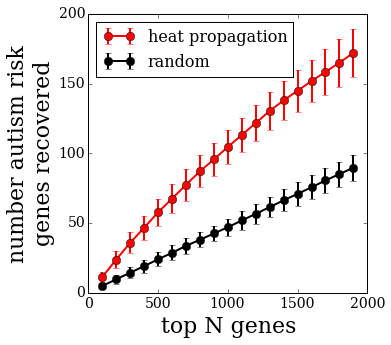

In [37]:
# plot the results

plt.figure(figsize=(5,5))
plt.errorbar(num_recovered.index.tolist(),
             list(num_recovered.mean(axis=1)),
             list(num_recovered.std(axis=1)),
             markersize=8,
             linewidth=2,
             label='heat propagation',fmt='ro-')
plt.errorbar(num_recovered_control.index.tolist(),
             list(num_recovered_control.mean(axis=1)),
             list(num_recovered_control.std(axis=1)),
             markersize=8,
             linewidth=2,
             fmt='ko-',label='random')
plt.xlabel('top N genes',fontsize=22)
plt.ylabel('number autism risk\ngenes recovered',fontsize=22)
plt.legend(loc='upper left',fontsize=16)
ax = plt.gca()
ax.tick_params(axis='both',which='major',labelsize=14)
#plt.title(str(num_seeds) + ' seed genes',fontsize=16)
#plt.savefig('../../figures/number_recovered_'+str(num_seeds)+'SeedGenes.png',dpi=200,bbox_inches='tight')

In [21]:
# how significantly different are heat_prop and random, at N = 200?
from scipy.stats import ranksums
tmp, p = ranksums(frac_recovered.loc[200],frac_recovered_control.loc[200])
print(p)

1.30290735256e-32
